In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


# Imports

In [2]:
from config import device, Settings
from commons import initialize
from utils.image_utils import ImageUtils
import torch
import cv2
import numpy as np

## Setting up Dataset

In [3]:
from network.dataset import *

settings = Settings('config/config.json')
initialize(settings)

Job: pp_wire_no_sum, Model: WDSS, Device: cuda
Model path: out\pp_wire_no_sum-WDSS\model
Log path: out\pp_wire_no_sum-WDSS\logs


In [9]:
train_dataset = WDSSDatasetCompressed(settings.train_dir, 119, 0)

# Load the buffers

In [10]:
image_no = 9

# rendered_image = ImageUtils.load_exr_image_opencv(get_full_path(rendered_img_path, image_no))
# rendered_image_t = ImageUtils.opencv_image_to_tensor(rendered_image)
# base_color = ImageUtils.load_exr_image_opencv(get_full_path(base_color_path, image_no))
# base_color_t = ImageUtils.opencv_image_to_tensor(base_color)
# motion_vector = ImageUtils.load_exr_image_opencv(get_full_path(motion_vector_path, image_no))
# motion_vector_t = ImageUtils.opencv_image_to_tensor(motion_vector)
# normal = ImageUtils.load_exr_image_opencv(get_full_path(world_normal_path, image_no))
# world_normal_t = ImageUtils.opencv_image_to_tensor(world_normal)
# depth = ImageUtils.load_exr_image_opencv(get_full_path(depth_path, image_no))
# depth_t = ImageUtils.opencv_image_to_tensor(depth)

# ImageUtils.display_images([rendered_image, base_color, motion_vector, world_normal, depth], 
#                           ['rendered_image', 'base_color', 'motion_vector', 'world_normal', 'depth'])

raw_frame = train_dataset._get_raw_frames(image_no)
lr_image = raw_frame[RawFrameGroup.LR].unsqueeze(0)
hr_image = raw_frame[RawFrameGroup.HR].unsqueeze(0)
temporal = raw_frame[RawFrameGroup.TEMPORAL].unsqueeze(0)

lr_base_color = raw_frame[RawFrameGroup.LR_GB][GB_Type.BASE_COLOR].unsqueeze(0)
lr_normal = raw_frame[RawFrameGroup.LR_GB][GB_Type.NORMAL].unsqueeze(0)
lr_depth = raw_frame[RawFrameGroup.LR_GB][GB_Type.DEPTH].unsqueeze(0)


hr_base_color = raw_frame[RawFrameGroup.HR_GB][GB_Type.BASE_COLOR].unsqueeze(0)
hr_normal = raw_frame[RawFrameGroup.HR_GB][GB_Type.NORMAL].unsqueeze(0)
hr_depth = raw_frame[RawFrameGroup.HR_GB][GB_Type.DEPTH].unsqueeze(0)

u_lr_image = ImageUtils.upsample(lr_image, 2)
u_lr_base_color = ImageUtils.upsample(lr_base_color, 2)
u_lr_normal = ImageUtils.upsample(lr_normal, 2)
u_lr_depth = ImageUtils.upsample(lr_depth, 2)

temporal_base_color = raw_frame[RawFrameGroup.TEMPORAL_GB][GB_Type.BASE_COLOR].unsqueeze(0)
temporal_normal = raw_frame[RawFrameGroup.TEMPORAL_GB][GB_Type.NORMAL].unsqueeze(0)
temporal_depth = raw_frame[RawFrameGroup.TEMPORAL_GB][GB_Type.DEPTH].unsqueeze(0)



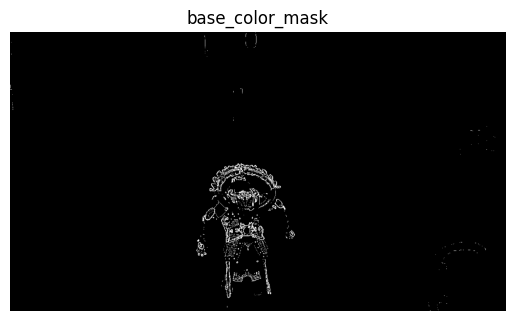

Base color mask: torch.Size([1, 1, 720, 1280])


In [15]:
def base_color_mask(hr_base_color, u_lr_base_color , threshold = 0.1):
    # Base color mask
    base_color_diff = torch.abs(hr_base_color - u_lr_base_color)
    base_color_diff = base_color_diff - threshold
    # Heaviside step function
    base_color_mask = torch.heaviside(base_color_diff, values=torch.tensor(0.0))
    # Convert the 3 channel mask to 1 channel
    base_color_mask = base_color_mask.sum(dim=1, keepdim=True)
    # Clamp the mask to 1
    base_color_mask = torch.clamp(base_color_mask, max=1)

    return base_color_mask

base_color_mask = base_color_mask(hr_base_color, u_lr_base_color)
ImageUtils.display_image(base_color_mask, 'base_color_mask')
print(f'Base color mask: {base_color_mask.shape}')

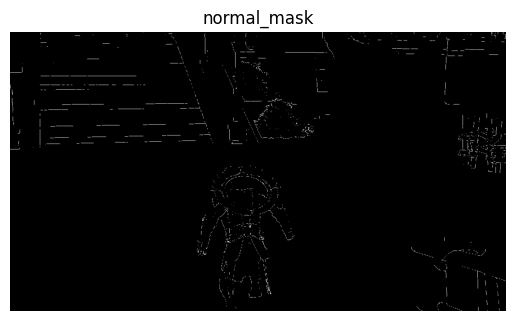

Normal mask: torch.Size([1, 1, 720, 1280])


In [16]:
# Normal mask
def normal_mask( hr_normal, u_lr_normal , threshold = 0.4):
    # Sum the product of the two tensors
    normal_dotted = torch.sum(hr_normal * u_lr_normal, dim=1, keepdim=True)

    # Subtraction
    normal_diff = 0.4 - normal_dotted
    # Heaviside step function
    normal_mask = torch.heaviside(normal_diff, values=torch.tensor(0.0))

    return normal_mask

normal_mask = normal_mask(hr_normal, u_lr_normal)
ImageUtils.display_image(normal_mask, 'normal_mask')
print(f'Normal mask: {normal_mask.shape}')

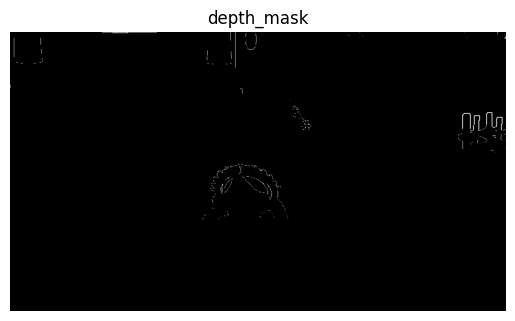

Depth mask: torch.Size([1, 1, 720, 1280])


In [17]:
# Depth mask
def depth_mask(hr_depth, u_lr_depth , threshold=0.04):
    # Subtract the upsampled depth from the high resolution depth keep shape
    depth_diff = hr_depth - u_lr_depth
    depth_diff = torch.abs(depth_diff)
    # Subtract 0.4 from the difference
    depth_diff = depth_diff - threshold

    # Heaviside step function
    depth_mask = torch.heaviside(depth_diff, values=torch.tensor(0.0))

    return depth_mask
    
depth_mask = depth_mask(hr_depth, u_lr_depth)
ImageUtils.display_image(depth_mask, 'depth_mask')
print(f'Depth mask: {depth_mask.shape}')

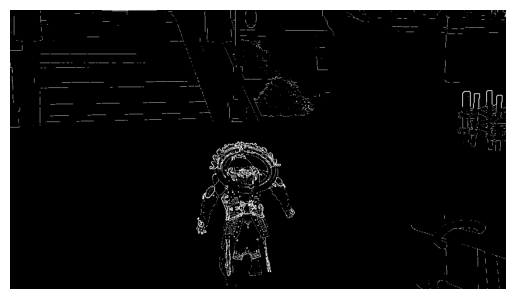

In [19]:
# Combine the masks
combined_mask = base_color_mask + normal_mask + depth_mask
# Clamp the combined mask to 1
combined_mask = torch.clamp(combined_mask, max=1)

# Display the combined mask
ImageUtils.display_image(combined_mask)


In [20]:
lr_motion_vector = raw_frame[RawFrameGroup.LR_GB][GB_Type.MOTION_VECTOR].unsqueeze(0)

u_lr_motion_vector = ImageUtils.upsample(lr_motion_vector, 2)

hr_motion_vector = raw_frame[RawFrameGroup.HR_GB][GB_Type.MOTION_VECTOR].unsqueeze(0)



In [21]:
def backward_warp(image, motion_vector):
    """
    Perform backward warping using motion vectors.

    Args:
        image (torch.Tensor): Previous frame (N, C, H, W).
        motion_vector (torch.Tensor): Motion vectors (N, 2, H, W).

    Returns:
        torch.Tensor: Warped image aligned to the current frame.
    """
    n, c, h, w = image.shape

    # Create normalized coordinate grid
    dx = torch.linspace(-1, 1, w, device=image.device)
    dy = torch.linspace(-1, 1, h, device=image.device)
    grid_y, grid_x = torch.meshgrid(dy, dx, indexing='ij')

    # Add motion vectors to the grid
    grid_x = grid_x.unsqueeze(0).expand(n, -1, -1) + (2 * motion_vector[:, 0] / w)
    grid_y = grid_y.unsqueeze(0).expand(n, -1, -1) + (2 * motion_vector[:, 1] / h)
    warped_grid = torch.stack((grid_x, grid_y), dim=-1)  # (N, H, W, 2)

    # Warp the image using grid_sample
    warped_image = torch.nn.functional.grid_sample(image, warped_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
    return warped_image

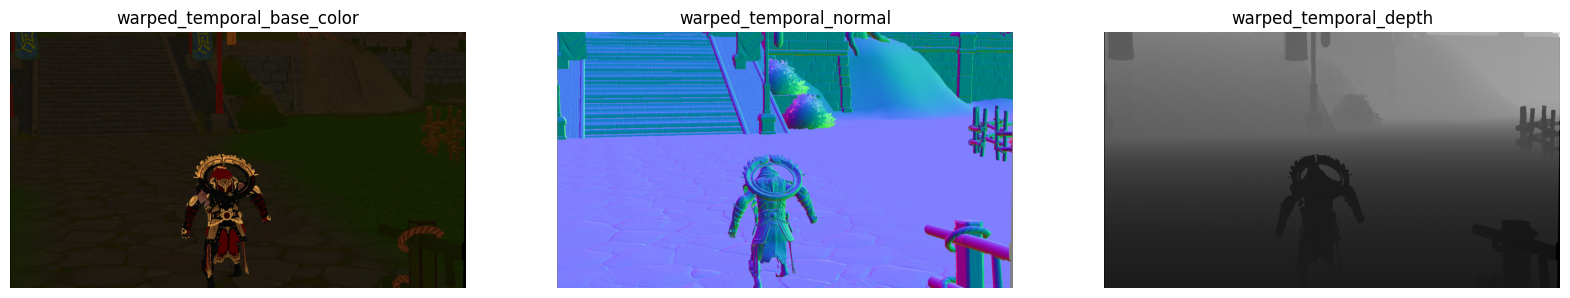

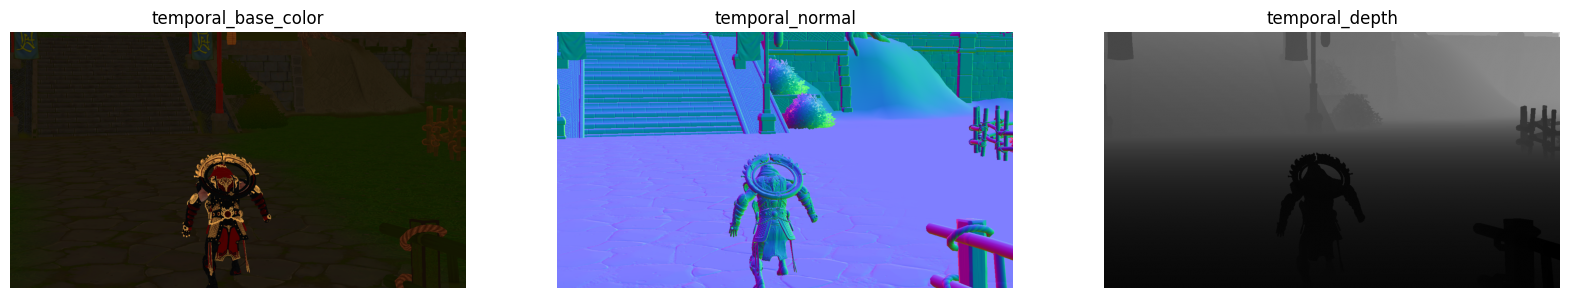

Warped temporal base color: torch.Size([1, 3, 720, 1280])
Warped temporal normal: torch.Size([1, 3, 720, 1280])
Warped temporal depth: torch.Size([1, 1, 720, 1280])


In [22]:
# Warp the temporal gs image
warped_temporal_base_color = backward_warp(temporal_base_color, hr_motion_vector)

# Warp the temporal normal image
warped_temporal_normal = backward_warp(temporal_normal, hr_motion_vector)

warped_temporal_depth = backward_warp(temporal_depth, hr_motion_vector)

ImageUtils.display_images([warped_temporal_base_color, warped_temporal_normal, warped_temporal_depth],  ['warped_temporal_base_color', 'warped_temporal_normal', 'warped_temporal_depth'])
ImageUtils.display_images([temporal_base_color, temporal_normal, temporal_depth],  ['temporal_base_color', 'temporal_normal', 'temporal_depth'])

print(f'Warped temporal base color: {warped_temporal_base_color.shape}')
print(f'Warped temporal normal: {warped_temporal_normal.shape}')
print(f'Warped temporal depth: {warped_temporal_depth.shape}')



torch.Size([1, 1, 720, 1280])
torch.Size([1, 3, 720, 1280])
torch.Size([1, 1, 720, 1280])


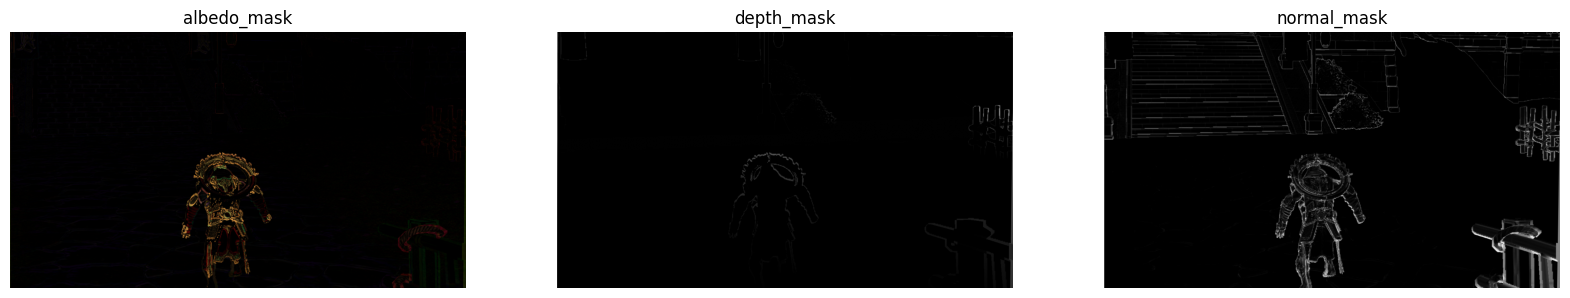

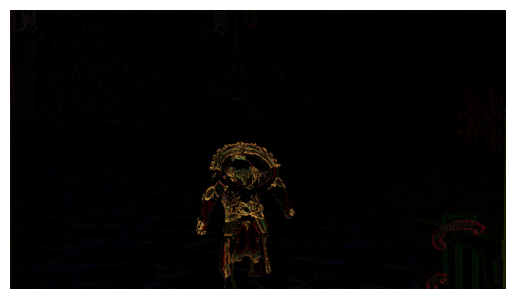

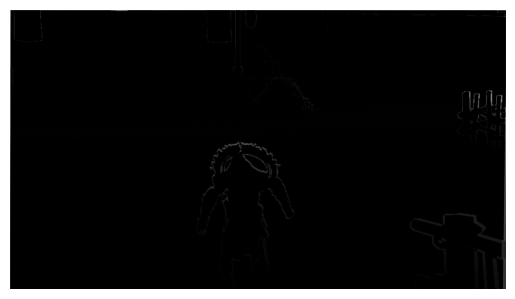

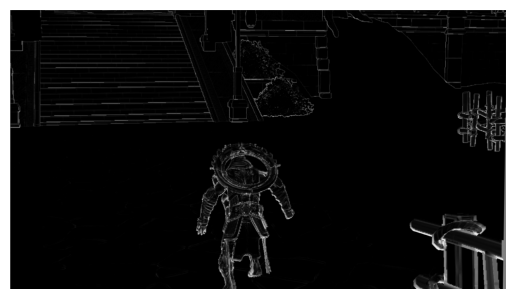

In [24]:
depth_mask = u_lr_depth - warped_temporal_depth
depth_mask = torch.abs(depth_mask)
print(depth_mask.shape)

albedo_mask = u_lr_base_color - warped_temporal_base_color
albedo_mask = torch.abs(albedo_mask)
print(albedo_mask.shape)

# Compute cosine similarity between the normals
cosine_similarity = torch.sum(u_lr_normal * warped_temporal_normal, dim=1, keepdim=True)  # (B, 1, H, W)
cosine_similarity = torch.clamp(cosine_similarity, -1.0, 1.0)
normal_mask = 1.0 - cosine_similarity  # (B, 1, H, W)
normal_mask = normal_mask / 2.0
print(normal_mask.shape)

concatinated_mask  = torch.cat((albedo_mask, depth_mask, normal_mask), dim=1)

ImageUtils.display_images([albedo_mask, depth_mask, normal_mask], ['albedo_mask', 'depth_mask', 'normal_mask'])
ImageUtils.display_image(albedo_mask)
ImageUtils.display_image(depth_mask)
ImageUtils.display_image(normal_mask)
